# Installing Required Libraries

In [1]:
pip install split_folders
pip intall tensorflow
pip install matplotlib
pip install numpy

# Importing splitfolders For Spliting Folders

In [2]:
import splitfolders

In [3]:
input_folders="input_dataset"
output="Bark_dataset/processed_data"
splitfolders.ratio(input_folders,output,seed=42,ratio=(.6,.2,.2))

In [4]:
help(splitfolders.ratio)

# Importing Required Modules 

In [5]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Spliting Data into Training,Testing and Validation

In [6]:
img_height,img_width = (224,224)
batch_size = 32
train_data_dir = r"Bark_dataset\processed_data\train"
valid_data_dir = r"Bark_dataset\processed_data\val"
test_data_dir = r"Bark_dataset\processed_data\test"


# Generating Training data

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
     shear_range = 0.2,
     zoom_range=0.2,
     horizontal_flip=True,
     validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
     train_data_dir,
     target_size=(img_height,img_width),
     batch_size=batch_size,
     class_mode="categorical",
     subset="training")

valid_generator = train_datagen.flow_from_directory(
     valid_data_dir,
     target_size=(img_height,img_width),
     batch_size=batch_size,
     class_mode="categorical",
     subset="validation")
                          


Found 2015 images belonging to 53 classes.
Found 422 images belonging to 53 classes.


# Generating Test data

In [8]:
test_generator = train_datagen.flow_from_directory(
     test_data_dir,
     target_size=(img_height,img_width),
     batch_size=1,
     class_mode="categorical",
     subset="validation")

Found 440 images belonging to 53 classes.


In [9]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

# Deffining our model = ResNet50

In [10]:
base_model= ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_generator,
                          epochs=10)

Epoch 1/10
63/63 [==============================] - 149s 2s/step - loss: 1.6498 - accuracy: 0.6124
Epoch 2/10
63/63 [==============================] - 131s 2s/step - loss: 0.4947 - accuracy: 0.8586
Epoch 3/10
63/63 [==============================] - 133s 2s/step - loss: 0.2900 - accuracy: 0.9186
Epoch 4/10
63/63 [==============================] - 139s 2s/step - loss: 0.2257 - accuracy: 0.9305
Epoch 5/10
63/63 [==============================] - 145s 2s/step - loss: 0.1919 - accuracy: 0.9429
Epoch 6/10
63/63 [==============================] - 137s 2s/step - loss: 0.1598 - accuracy: 0.9533
Epoch 7/10
63/63 [==============================] - 2304s 37s/step - loss: 0.1351 - accuracy: 0.9623
Epoch 8/10
63/63 [==============================] - 191s 3s/step - loss: 0.1324 - accuracy: 0.9588
Epoch 9/10
63/63 [==============================] - 188s 3s/step - loss: 0.0950 - accuracy: 0.9702
Epoch 10/10
63/63 [==============================] - 192s 3s/step - loss: 0.0864 - accuracy: 0.9757


# Saving our model as h5 file

In [11]:
model.save('Bark_dataset\Saved_Model\ResNet50_barks.h5')


# Testing our model accuracy

In [12]:
test_loss,test_acc = model.evaluate(test_generator, verbose=2)
print=('\naTest accuracy:',test_acc)

440/440 - 76s - loss: 0.7686 - accuracy: 0.8045 - 76s/epoch - 173ms/step


# Script for generating confusion_matrix

1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 218ms/step


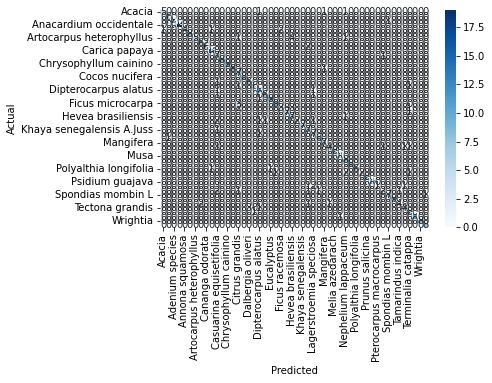

In [13]:
import pandas as pd 
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('Bark_dataset\Saved_Model\ResNet50_barks.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob =[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(test_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(test_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap="Blues", annot=True,fmt='d')
plt.show()
# print('test accuracy:{}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))
